# Import Library

In [109]:
import numpy as np
import pandas as pd
import json
from utils.utils import *

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import category_encoders as ce

# Load Data

In [110]:
df_test = pd.read_csv('data/pretest/pretest.csv')
print(df_test.dtypes)

MOFname                                           object
volume [A^3]                                     float64
weight [u]                                       float64
surface_area [m^2/g]                             float64
void_fraction                                    float64
void_volume [cm^3/g]                             float64
functional_groups                                 object
metal_linker                                       int64
organic_linker1                                    int64
organic_linker2                                    int64
topology                                          object
CO2/N2_selectivity                               float64
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]    float64
dtype: object


In [111]:
df_test.isna().sum()

MOFname                                           0
volume [A^3]                                      0
weight [u]                                        0
surface_area [m^2/g]                              0
void_fraction                                     0
void_volume [cm^3/g]                              0
functional_groups                                21
metal_linker                                      0
organic_linker1                                   0
organic_linker2                                   0
topology                                          0
CO2/N2_selectivity                                0
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]     0
dtype: int64

# Load dependent data

In [112]:
features = json.load(open('model/general/features.json', 'r'))
features_idx = json.load(open('model/general/features_idx.json', 'r'))

topo_encoder = json.load(open('model/general/encoder/topology_encoder.json', 'r'))
func_encoder = json.load(open('model/general/encoder/functional_groups_encoder.json', 'r'))
hash_encoder = pickle.load(open('model/hash_encode_topology.pkl', 'rb'))

# Preprocessing Data

## Insert Density

In [113]:
df_test.insert(loc=3, column="density [g/cm^3]", value=(df_test["weight [u]"] / df_test["volume [A^3]"]) * 1.66054)

## Generate catalog

In [114]:
generate_selectivity_catalog(df_test)

,MOFname,volume [A^3],weight [u],density [g/cm^3],surface_area [m^2/g],void_fraction,void_volume [cm^3/g],functional_groups,metal_linker,organic_linker1,organic_linker2,catalog CO2/N2,topology,CO2/N2_selectivity,heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]
0,mof_unit_pretest_1,6288.293858,2271.687140,0.599881,4148.48,0.41225,0.6872,OPr,4,7,27,1.0,acs,14.048791,5.604779
1,mof_unit_pretest_2,1790.506437,887.747320,0.823309,2191.34,0.30231,0.3672,HCO-OPr,2,4,26,1.0,pcu,20.217222,6.148776
2,mof_unit_pretest_3,2348.969203,1239.765880,0.876419,2030.88,0.28533,0.3256,SO3H-OH,3,18,22,1.0,pcu,33.108662,6.164397
3,mof_unit_pretest_4,2941.571525,1147.951400,0.648027,3587.13,0.41963,0.6475,Et-OH,2,8,15,1.0,pcu,12.800562,5.164957
4,mof_unit_pretest_5,705.397601,643.270740,1.514290,0.00,0.07060,0.0466,Cl-H,3,10,22,1.0,pcu,23.395617,7.090687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,mof_unit_pretest_1996,5111.109714,1578.082220,0.512701,3630.31,0.58981,1.1504,COOH-NH2,2,1,14,0.0,nbo,4.778698,3.675003
1996,mof_unit_pretest_1997,911.269336,481.279680,0.877001,2546.02,0.36132,0.4120,CN-H,2,10,20,0.0,pcu,6.883387,3.732121
1997,mof_unit_pretest_1998,4236.596494,1127.792600,0.442040,4296.42,0.60298,1.3641,HCO-NH2,2,7,20,0.0,pcu,5.270734,3.354425
1998,mof_unit_pretest_1999,22861.645381,3492.712720,0.253691,6252.01,0.75732,2.9852,Me-OH,2,6,11,0.0,nbo,3.172914,2.643592


## Encode Data

In [115]:
encoder = {'functional_groups': func_encoder}
df_test = df_test.replace(encoder)

topo_encode = hash_encoder.transform(df_test['topology'])

topo_name = list(topo_encode.columns)
topo_rename = {}

for i in range(len(topo_name)):
    topo_rename[topo_name[i]] = "topo_{}".format(i)

topo_encode = topo_encode.rename(columns = topo_rename)

df_test = df_test.drop('topology', axis=1)
df_test = pd.concat([topo_encode, df_test], axis=1)
print(df_test.dtypes)

topo_0                                             int64
topo_1                                             int64
topo_2                                             int64
topo_3                                             int64
topo_4                                             int64
topo_5                                             int64
topo_6                                             int64
topo_7                                             int64
topo_8                                             int64
topo_9                                             int64
MOFname                                           object
volume [A^3]                                     float64
weight [u]                                       float64
density [g/cm^3]                                 float64
surface_area [m^2/g]                             float64
void_fraction                                    float64
void_volume [cm^3/g]                             float64
functional_groups              

## Select features

In [116]:
X = df_test[features].values
print(X.shape)

(2000, 21)


## Convert CO2/N2 selectivity by square root selectivity and multiply by heat adsorption

In [117]:
# X[:, features_idx['CO2/N2_selectivity']] = np.sqrt(X[:, features_idx['CO2/N2_selectivity']]) * X[:, features_idx['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]']]

## Scale Data

In [118]:
sc = pickle.load(open('model/general/standardscaler.pkl', 'rb'))
X = sc.transform(X)

# Model

In [119]:
model = xgb.XGBRegressor()
model.load_model('model/model.json')

y = model.predict(X)

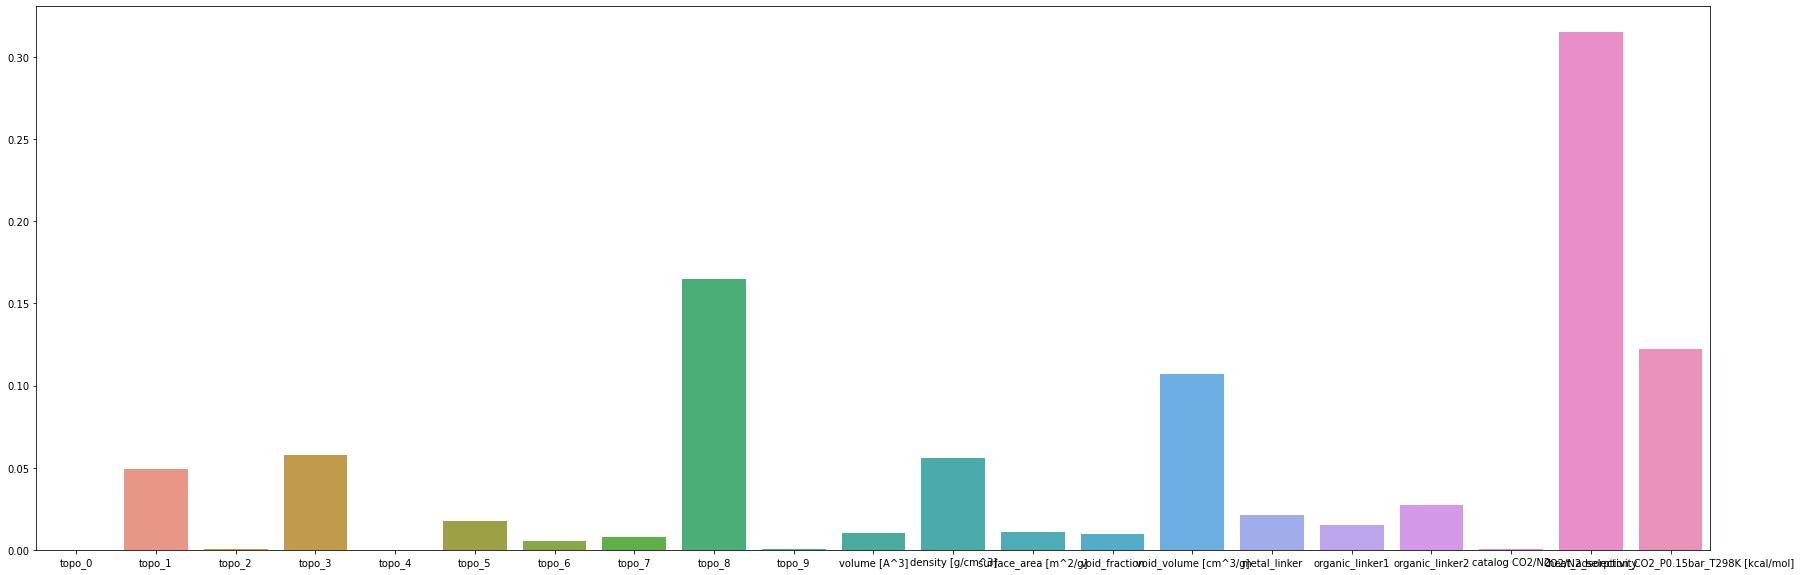

In [120]:
plt.figure(figsize=(30, 10))
sns.barplot(x=features, y=model.feature_importances_)
plt.show()

In [121]:
id_ = np.array(df_test['MOFname'])

cut_mof_unit = lambda x: x[9:]
id_ = np.array(list(map(cut_mof_unit, id_)))
d = {'id': id_, 'CO2_working_capacity [mL/g]': y}

df_inference = pd.DataFrame(d)

In [122]:
df_inference.to_csv('submission.csv', index=False)